# TUT Acoustic Scenes Dataset

Having a look at the dataset used to train the acoustic scene classifier

In [1]:
import os
import pandas as pd

TRAINING_DIR = '../data/scenes_training_set'
VALIDATION_DIR = '../data/scenes_validation_set'

In [2]:
# Look at training data
def load_meta_data(path):
    meta_path = os.path.join(path, 'meta.txt')
    with open(meta_path, 'r') as f:
        meta_text = f.read()

    data = []
    for line in meta_text.split('\n'):
        if not line:
            continue
        filename, label = line.split("\t")
        filename_cleaned = filename.replace("audio/", "")
        data.append({"filename": filename_cleaned, "label": label})

    return pd.DataFrame(data=data)

training_meta_df = load_meta_data(TRAINING_DIR)
validation_meta_df = load_meta_data(VALIDATION_DIR)

In [3]:
training_meta_df.head()

,filename,label
0,a001_0_30.wav,residential_area
1,a001_120_150.wav,residential_area
2,a001_150_180.wav,residential_area
3,a001_30_60.wav,residential_area
4,a001_60_90.wav,residential_area


In [4]:
validation_meta_df.head()

,filename,label
0,178.wav,bus
1,188.wav,park
2,185.wav,forest_path
3,143.wav,beach
4,62.wav,park


In [5]:
len(training_meta_df)

1170

In [6]:
len(validation_meta_df)

390

In [7]:
training_meta_df.groupby('label').count()

,filename
label,
beach,78
bus,78
cafe/restaurant,78
car,78
city_center,78
forest_path,78
grocery_store,78
home,78
library,78


In [8]:
validation_meta_df.groupby('label').count()

,filename
label,
beach,26
bus,26
cafe/restaurant,26
car,26
city_center,26
forest_path,26
grocery_store,26
home,26
library,26


In [9]:
import torch
from torch.utils.data import DataLoader

from src.datasets.scene_dataset import SceneDataset
from src.models.scene_net import SceneNet

CHECKPOINT = 'checkpoints/scene-net-1570343356.ckpt'

In [10]:
training_set = SceneDataset(train=True)
validation_set = SceneDataset(train=False)

  5%|▌         | 54/1015 [00:00<00:01, 535.84it/s]


Loading training dataset into memory.
Loading class labels...
Loading data...


  2%|▏         | 9/390 [00:00<00:04, 77.53it/s]

Done loading dataset into memory: loaded 28420 items.


Loading validation dataset into memory.
Loading class labels...
Loading data...


100%|██████████| 390/390 [00:05<00:00, 65.93it/s]

Done loading dataset into memory: loaded 10920 items.



In [11]:
num_labels = len(training_set.labels)
net = SceneNet(num_labels=num_labels)
net.load_state_dict(torch.load(CHECKPOINT))
net.eval()
print('Loaded')

Loaded


In [22]:
samples = (validation_set[i] for i in range(5000))
labels_true = []
labels_pred = []
for sample in samples:
    audio, label = sample
    audio = audio.view(1, 1, -1)
    log_predictions = net(audio)
    predictions = torch.exp(log_predictions)
    pred_idx = predictions.argmax().item()
    label_true = training_set.idx_to_label[label]
    label_pred = training_set.idx_to_label[pred_idx]
    labels_true.append(label_true)
    labels_pred.append(label_pred)

In [23]:
assert len(labels_true) == len(labels_pred)
total = len(labels_true)
correct = 0
for idx in range(total):
    if labels_true[idx] == labels_pred[idx]:
        correct += 1

accuracy = correct / float(total)
print(f'Accuracy: {accuracy:0.2f}')

Accuracy: 0.48


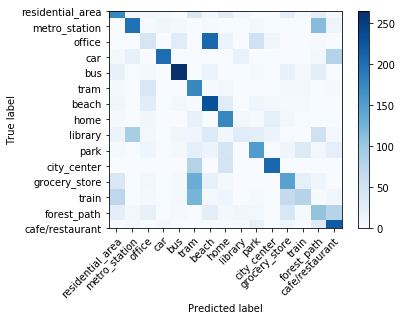

In [24]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np
# Compute confusion matrix
cm = confusion_matrix(labels_true, labels_pred)
classes = set(validation_set.idx_to_label.values())

cmap = plt.cm.Blues
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
ax.figure.colorbar(im, ax=ax)
# We want to show all ticks...
ax.set(
    xticks=np.arange(cm.shape[1]),
    yticks=np.arange(cm.shape[0]),
    xticklabels=classes, yticklabels=classes,
    ylabel='True label',
    xlabel='Predicted label'
)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

plt.show()